In [ ]:
%tensorflow_version  2.x
! pip install -q keras==2.3.0

     |████████████████████████████████| 378kB 3.4MB/s 


In [ ]:
# Per sapere che GPU è assegnata 

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
! pip install pyGPGO

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer, classification_report
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import class_weight



from xgboost.sklearn import XGBClassifier
import xgboost

from keras import models, layers, optimizers, metrics, callbacks
from tensorflow import random


from keras.wrappers.scikit_learn import KerasClassifier


from pyGPGO.surrogates.RandomForest import RandomForest
from pyGPGO.GPGO import GPGO
from pyGPGO.acquisition import Acquisition


import requests

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load Data

In [ ]:
data = pd.read_csv('/content/drive/My Drive/progetto_aml/dataset/train_prepocessed.csv')

# Funzioni utilli

In [ ]:
# Funzioni per calcolare ndcg

def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)


def ndcg_score(ground_truth, predictions, k=5):
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) ))
    T = lb.transform(ground_truth)

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)



ndcg_scorer = make_scorer(ndcg_score, needs_proba=True, k=5)

In [ ]:
# Top_n accuracy

def top_n_accuracy(y_true, y_pred_prob, n = 5):
    topn = np.argsort(y_pred_prob, axis = 1)[:,-n:]
    acc = np.mean(np.array([1 if y_true[k] in topn[k] else 0 for k in range(len(topn))]))
    return(acc)

In [ ]:
# Messaggio su Telegram

def telegram_bot_sendtext(bot_message):
    
    bot_token = '937044171:AAGGDmJcUTkkvDaOwcKrnHUyj9XUND7d52A'
    bot_chatID = '166942243'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + str(bot_message)

    response = requests.get(send_text)

    return response.json()

In [ ]:
def resultDataframe(hyperparams,score, initial):
  result = pd.DataFrame(hyperparams,columns=['lr','max_depth', 'n_estimator', 'max_delta_step'])
  result['ndcg'] = score
  result['phase']="increment"
  result.loc[0:initial-1,'phase']='initial'
  return result

# AutoML XGboost

In [ ]:
data_prova = data.copy()

In [ ]:
data_prova.drop("id", axis = 1, inplace = True)

In [ ]:
X_train_cval, X_test = train_test_split(data_prova, test_size = 0.1, stratify = data_prova["country_destination"], random_state = 42)

In [ ]:
y_train = X_train_cval.pop("country_destination")
y_test = X_test.pop("country_destination")

In [ ]:
# Per cross-validation
Kfold = StratifiedKFold(5, shuffle=True, random_state=42)

In [ ]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [ ]:
# Definizione spazio di ricerca
range_lr = [0.01, 1]
n_max_depth = [1, 20]
n_estimators = [1, 100] 
n_max_delta = [1, 10]
param = {'lr': ('cont', range_lr), 
         'n_max_depth': ('int', n_max_depth),
         'n_estimators' : ('int', n_estimators),
         'n_max_delta' : ('int', n_max_delta)}

rf_model = RandomForest()

f_acq = Acquisition(mode = "ExpectedImprovement")
f_acq1 = Acquisition(mode = "ProbabilityImprovement") 

In [ ]:
# Funzione da massimizzare per AutoML
def compute_ndcg(lr, n_max_depth, n_estimators, n_max_delta):
    xgb = XGBClassifier(max_depth = int(n_max_depth), learning_rate = lr, n_estimators=int(n_estimators),
                        objective = 'multi:softprob', colsample_bytree = 1, 
                        seed=42, n_jobs = -1, tree_method = "gpu_hist", max_delta_step = int(n_max_delta), verbosity=0)
    
    cval_score = []
    i = 1
    for train_index, test_index in Kfold.split(X_train_cval, encoded_y_train):
        
        X_train, X_val = X_train_cval.values[train_index], X_train_cval.values[test_index]
        y_train, y_val = encoded_y_train[train_index], encoded_y_train[test_index]

        xgb.fit(X_train, y_train, 
                verbose = 0)
        
        y_pred_prob = xgb.predict_proba(X_val)
        actual = ndcg_score(y_val, y_pred_prob, k = 5)
        cval_score.append(actual)
        print("Numero Fold: " + str(i))
        i = i+1


    return np.mean(cval_score)

In [ ]:
# Funzione di acquisizione expected improvement
np.random.seed(42)

SMBO_exp = GPGO(rf_model, f_acq,
                compute_ndcg,
                param, n_jobs = -1)
SMBO_exp.run(init_evals=10,
             max_iter=70)

In [ ]:
# I risultati migliori vengono mandati tramite telegram
telegram_bot_sendtext("Per XGBoost con f acq exp gli iperparametri migliori risultano : " + str(SMBO_exp.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_exp.getResult()[1]))

In [ ]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_exp.GP.X, SMBO_exp.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_exp.csv", index=False)

In [ ]:
#Funzione di acquizione probability improvement

np.random.seed(42)

SMBO_prob = GPGO(rf_model, f_acq1,
                compute_ndcg,
                param, n_jobs = -1)
SMBO_prob.run(init_evals=10,
             max_iter=70)

In [ ]:
telegram_bot_sendtext("Per XGBoost con f acq prob gli iperparametri migliori risultano : " + str(SMBO_prob.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_prob.getResult()[1]))

In [ ]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_prob.GP.X, SMBO_prob.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_prob.csv", index=False)

### Confronto risultati

In [ ]:
result_exp = pd.read_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_exp.csv")
result_prob = pd.read_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_prob.csv")

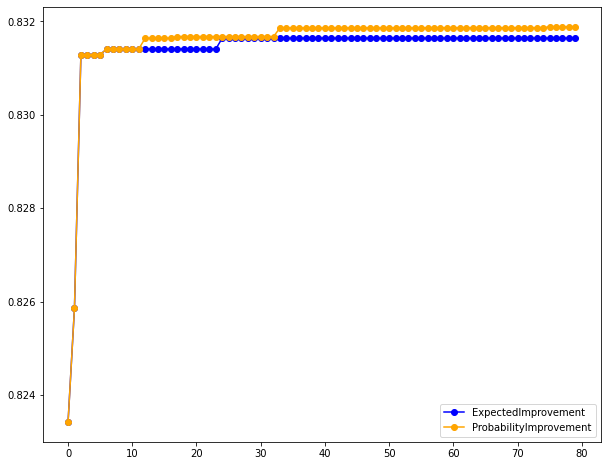

In [ ]:
ndcg_exp = np.maximum.accumulate(result_exp["ndcg"])
ndcg_prob = np.maximum.accumulate(result_prob["ndcg"])

plt.figure(figsize=(10,8))
plt.plot(ndcg_exp,marker='o',color='blue',label="ExpectedImprovement")
plt.plot(ndcg_prob,marker='o',color='orange',label="ProbabilityImprovement")
plt.legend()
plt.savefig("/content/drive/My Drive/AML/Progetto/AutoML.png")

# AutoML NN

In [ ]:
n_classes = len(np.unique(data["country_destination"]))
n_features = data.shape[1] - 2 

In [ ]:
def resultDataframe(hyperparams,score, initial):
  result = pd.DataFrame(hyperparams,columns=['lr','n_neuron', 'n_neuron1', 'n_layers' , 'n_batch_size'])
  result['ndcg'] = score
  result['phase']="increment"
  result.loc[0:initial-1,'phase']='initial'
  return result

In [ ]:
def create_model(n_neuron, n_neuron1, n_layers): 
    model = models.Sequential()

    model.add(layers.Dense(int(n_neuron), input_dim=n_features, activation="relu"))

    for i in range(int(n_layers)):
        model.add(layers.Dense(int(n_neuron1), activation="relu"))

    model.add(layers.Dense(n_classes, activation="softmax"))
    
    return model

In [ ]:
# Spazio di ricerca

range_lr = [0.0001, 0.01]
range_neuron = [256, 1024]
range_neuron1 = [16, 1024]
range_layers = [0, 3]
range_batch_size = [1, 128]


param = {'lr': ('cont', range_lr), 
         'n_neuron': ('int', range_neuron),
         'n_neuron1' : ('int', range_neuron1),
         'n_layers' : ('int', range_layers),
         'n_batch_size' : ('int', range_batch_size)#,
         #'drop' : ('cont', range_drop)
         }

rf_model = RandomForest()

f_acq = Acquisition(mode = "ExpectedImprovement")
f_acq1 = Acquisition(mode = "ProbabilityImprovement") 

### Cross Validation (troppo lenta, si usa semplicemente la validation)

In [ ]:
data_prova = data.copy()

In [ ]:
data_prova.drop("id", axis = 1, inplace = True)

In [ ]:
X_train_cval, X_test = train_test_split(data_prova, test_size = 0.1, stratify = data_prova["country_destination"], random_state = 42)

In [ ]:
y_train = X_train_cval.pop("country_destination")
y_test = X_test.pop("country_destination")

In [ ]:
n_classes = len(np.unique(y_train))
n_features = X_train_cval.shape[1]

In [ ]:
Kfold = StratifiedKFold(5, shuffle=True, random_state=42)

In [ ]:
label_encoder = LabelEncoder()
encoded_y_train = label_encoder.fit_transform(y_train)
encoded_y_test = label_encoder.fit_transform(y_test)

In [ ]:
# Definizione Early Stopping
es = callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')

In [ ]:
def compute_ndcg(lr, n_neuron, n_neuron1, n_layers, drop, n_batch_size):

    model = create_model(n_neuron, n_neuron1, n_layers, drop)

    model.compile(optimizer=optimizers.adam(learning_rate = lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=["acc"])
    
    cval_score = []
    i = 1
    for train_index, test_index in Kfold.split(X_train_cval, encoded_y_train):
        
        X_train, X_val = X_train_cval.values[train_index], X_train_cval.values[test_index]
        y_train, y_val = encoded_y_train[train_index], encoded_y_train[test_index]

        class_weights = class_weight.compute_class_weight('balanced', 
                                                          np.unique(y_train), y_train)
        
        model.fit(X_train, y_train, 
                  batch_size = int(n_batch_size),
                  epochs = 100,
                  class_weight = class_weights,
                  callbacks = [es],
                  verbose = 0)
        
        y_pred_prob = model.predict(X_val)
        actual = ndcg_score(y_val, y_pred_prob, k = 5)
        cval_score.append(actual)
        print("Numero Fold: " + str(i))
        i = i+1

    return np.mean(cval_score)

In [ ]:
np.random.seed(42)

SMBO_exp_nn = GPGO(rf_model, f_acq,
                compute_ndcg,
                param, n_jobs = 1)
SMBO_exp_nn.run(init_evals=2,
             max_iter=3)

In [ ]:
# I risultati migliori vengono mandati tramite telegram
telegram_bot_sendtext("Per NN con f acq exp gli iperparametri migliori risultano : " + str(SMBO_exp_nn.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_exp_nn.getResult()[1]))

In [ ]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_exp_nn.GP.X, SMBO_exp_nn.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_exp_nn.csv", index=False)

In [ ]:
#Funzione di acquizione probability improvement

np.random.seed(42)

SMBO_prob_nn = GPGO(rf_model, f_acq1,
                compute_ndcg,
                param, n_jobs = 1)
SMBO_prob_nn.run(init_evals=10,
             max_iter=70)

In [ ]:
telegram_bot_sendtext("Per NN con f acq prob gli iperparametri migliori risultano : " + str(SMBO_prob_nn.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_prob_nn.getResult()[1]))

In [ ]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_prob_nn.GP.X, SMBO_prob_nn.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_prob_nn.csv", index=False)

### Validation normale

In [ ]:
data_prova = data.copy()

In [ ]:
data_prova.drop("id", axis = 1, inplace = True)

In [ ]:
train, test = train_test_split(data_prova, test_size = 0.1, stratify = data_prova["country_destination"], random_state = 42)

In [ ]:
# Definizione Early Stopping
es = callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [ ]:
# Funzione da massimizzare
def compute_ndcg(lr, n_neuron, n_neuron1, n_layers, n_batch_size):

    model = create_model(n_neuron, n_neuron1, n_layers)

    model.compile(optimizer=optimizers.adam(learning_rate = lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=["acc"])
    
    X_train, X_test = train_test_split(train, test_size = 0.15, stratify = train["country_destination"], random_state = 42)
    y_train = X_train.pop("country_destination")
    y_test = X_test.pop("country_destination")
    label_encoder = LabelEncoder()
    encoded_y_train = label_encoder.fit_transform(y_train)
    encoded_y_test = label_encoder.fit_transform(y_test)


    class_weights = class_weight.compute_class_weight('balanced', 
                                                        np.unique(y_train), y_train)
    
    model.fit(X_train, encoded_y_train, 
              batch_size = int(n_batch_size),
              epochs = 100,
              class_weight = class_weights,
              validation_split = 0.2,
              callbacks = [es],
              verbose = 0)
    
    y_pred_prob = model.predict(X_test)
    score = ndcg_score(encoded_y_test, y_pred_prob, k = 5)

    return score

In [ ]:
np.random.seed(42)
random.set_seed(42)

SMBO_exp_nn = GPGO(rf_model, f_acq,
                   compute_ndcg,
                   param, n_jobs = 1)
SMBO_exp_nn.run(init_evals=10,
                max_iter=70)

In [ ]:
# I risultati migliori vengono mandati tramite telegram
telegram_bot_sendtext("Per NN con f acq exp gli iperparametri migliori risultano : " + str(SMBO_exp_nn.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_exp_nn.getResult()[1]))

In [ ]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_exp_nn.GP.X, SMBO_exp_nn.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_exp_nn.csv", index=False)

In [ ]:
#Funzione di acquizione probability improvement

np.random.seed(42)
random.set_seed(42)

SMBO_prob_nn = GPGO(rf_model, f_acq1,
                compute_ndcg,
                param, n_jobs = 1)
SMBO_prob_nn.run(init_evals=10,
             max_iter=70)

In [ ]:
telegram_bot_sendtext("Per XGBoost con f acq prob gli iperparametri migliori risultano : " + str(SMBO_prob_nn.getResult()[0]) + "." + "\n\n" + "E l'NDCG è pari a: " + str(SMBO_prob_nn.getResult()[1]))

In [ ]:
# Vengono salvati i risultati in un dataframe
result = resultDataframe(SMBO_prob_nn.GP.X, SMBO_prob_nn.GP.y, initial=10)
result.to_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_prob_nn.csv", index=False)

### Confronto risultati


In [ ]:
result_exp = pd.read_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_exp_nn.csv")
result_prob = pd.read_csv("/content/drive/My Drive/AML/Progetto/risultati_SMBO_prob_nn.csv")

In [ ]:
ndcg_exp_nn = np.maximum.accumulate(result_exp)
ndcg_prob_nn = np.maximum.accumulate(result_prob)

plt.figure(figsize=(10,8))
plt.plot(ndcg_exp_nn,marker='o',color='blue',label="ExpectedImprovement")
plt.plot(ndcg_prob_nn,marker='o',color='orange',label="ProbabilityImprovement")
plt.legend()
plt.show()

plt.savefig("/content/drive/My Drive/AML/Progetto/AutoML_nn.png")